<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/xveganx_icon.png">
*This notebook contains ongoing research material from [gully](https://twitter.com/gully_); the content is available [on GitHub](https://github.com/BrownDwarf/xveganx).*


<!--NAVIGATION-->
< [IW Tau A, Enhanced processing](02.02-IWTau-A-Enhanced-processing.ipynb) | [Contents](Index.ipynb) | [Spectral inference with Starfish Mixture Models](03.00-Spectral-Inference-with-Starfish.ipynb) >

# V827 Manual IGRINS spectrum cleaning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
from astropy.io import fits
import h5py

/Users/obsidian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set the date

In [3]:
date = 20141121

## H-Band

In [4]:
dir1 = '../data/IGRINS/MGS_data_full/20141120/'

In [5]:
! ls ../data/IGRINS/MGS_data_full/20141120/

SDCH_20141120_0104.slit_profile.json   SDCK_20141120_0104.slit_profile.json
SDCH_20141120_0104.sn.fits             SDCK_20141120_0104.sn.fits
SDCH_20141120_0104.spec.fits           SDCK_20141120_0104.spec.fits
SDCH_20141120_0104.spec2d.fits         SDCK_20141120_0104.spec2d.fits
SDCH_20141120_0104.spec_a0v.fits       SDCK_20141120_0104.spec_a0v.fits
SDCH_20141120_0104.var2d.fits          SDCK_20141120_0104.var2d.fits
SDCH_20141120_0104.variance.fits       SDCK_20141120_0104.variance.fits
SDCH_20141120_0108.slit_profile.json   SDCK_20141120_0108.slit_profile.json
SDCH_20141120_0108.sn.fits             SDCK_20141120_0108.sn.fits
SDCH_20141120_0108.spec.fits           SDCK_20141120_0108.spec.fits
SDCH_20141120_0108.spec2d.fits         SDCK_20141120_0108.spec2d.fits
SDCH_20141120_0108.spec_flattened.fits SDCK_20141120_0108.spec_flattened.fits
SDCH_20141120_0108.var2d.fits          SDCK_20141120_0108.var2d.fits
SDCH_20141120_0108.variance.fits       SDCK_20141120_0108.variance.fits
SDCH_201

In [6]:
base = 'SDCH_20141120_'
num_A0V = '0108'
num_targ = '0104'
hdu_raw = fits.open(dir1+base+num_A0V+'.spec.fits')
hdu_f   = fits.open(dir1+base+num_A0V+'.spec_flattened.fits')
                   
hdu_var = fits.open(dir1+base+num_A0V+'.variance.fits')
hdu_tar = fits.open(dir1+base+num_targ+'.spec.fits')
tar_var = fits.open(dir1+base+num_targ+'.variance.fits')
hdr = hdu_tar[0].header

### Do the telluric correction
$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} \times \hat{f}_{std}$

$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 } \times \hat{f}_{std}$

In [7]:
f_hat_std = hdu_f[4].data/np.nanmean(hdu_f[4].data)
f_star = hdu_tar[0].data/hdu_raw[0].data*f_hat_std
term1 = hdu_var[0].data / hdu_raw[0].data**2
term2 = tar_var[0].data / hdu_tar[0].data**2
sig_star = f_star * np.sqrt( term1 + term2 )*f_hat_std

## Plot it

We will trim between pixel 450 and 1950.

In [8]:
o=0

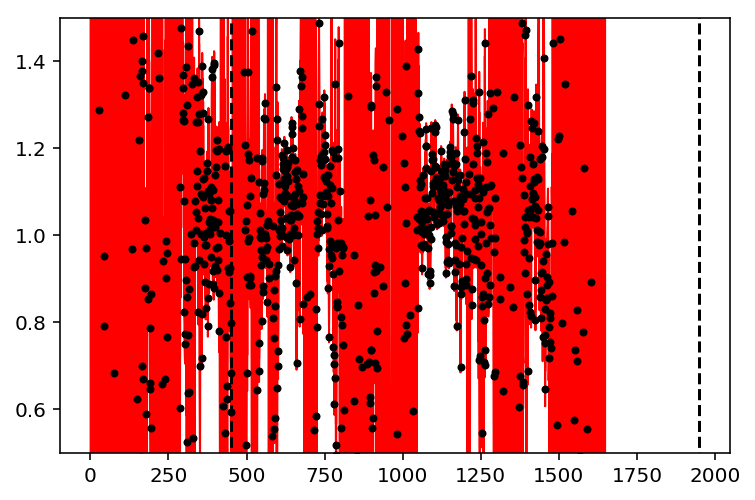

In [9]:
norm = np.nanmedian(f_star[o,:])
fls_out = f_star[o,:]/norm
sig_out = sig_star[o,:]/norm
wls_out = hdu_tar[1].data[o,:]*10000.0
sig = sig_out

pix = np.arange(2048)
plt.plot(pix, fls_out, 'k.')

plt.fill_between(pix, fls_out-sig, fls_out+sig, color='r')

plt.vlines(450, 0, 2, linestyles='--')
plt.vlines(1950, 0, 2, linestyles='--')
plt.ylim(0.5, 1.5)
o +=1

In [12]:
#hdu_tar[0].header

In [10]:
#! mkdir ../data/reduced

In [11]:
lft = 450
rgt = 1950

for o in range(28):
    m = o + 98
    out_name = '../data/IGRINS/reduced/V827_IGRINS_{}_m{:03d}.hdf5'.format(date, m)
    fls_out = f_star[o,lft:rgt]
    norm = np.nanmedian(fls_out)
    fls_out = fls_out / norm
    sig_out = sig_star[o,lft:rgt] / norm
    wls_out = hdu_tar[1].data[o,lft:rgt]*10000.0
    msk_out = np.ones(len(wls_out), dtype=int)
    f_new = h5py.File(out_name, 'w')
    f_new.create_dataset('fls', data=fls_out)
    f_new.create_dataset('wls', data=wls_out)
    f_new.create_dataset('sigmas', data=sig_out)
    f_new.create_dataset('masks', data=msk_out)
    print("{:03d}: {:.0f}  -  {:.0f}   {}".format(m, wls_out[0], wls_out[-1], out_name))
    f_new.close()

098: 18154  -  18335   ../data/IGRINS/reduced/V827_IGRINS_20141121_m098.hdf5
099: 17975  -  18155   ../data/IGRINS/reduced/V827_IGRINS_20141121_m099.hdf5
100: 17800  -  17978   ../data/IGRINS/reduced/V827_IGRINS_20141121_m100.hdf5
101: 17628  -  17805   ../data/IGRINS/reduced/V827_IGRINS_20141121_m101.hdf5
102: 17460  -  17635   ../data/IGRINS/reduced/V827_IGRINS_20141121_m102.hdf5
103: 17295  -  17468   ../data/IGRINS/reduced/V827_IGRINS_20141121_m103.hdf5
104: 17133  -  17305   ../data/IGRINS/reduced/V827_IGRINS_20141121_m104.hdf5
105: 16975  -  17145   ../data/IGRINS/reduced/V827_IGRINS_20141121_m105.hdf5
106: 16819  -  16988   ../data/IGRINS/reduced/V827_IGRINS_20141121_m106.hdf5
107: 16667  -  16834   ../data/IGRINS/reduced/V827_IGRINS_20141121_m107.hdf5
108: 16517  -  16682   ../data/IGRINS/reduced/V827_IGRINS_20141121_m108.hdf5
109: 16370  -  16534   ../data/IGRINS/reduced/V827_IGRINS_20141121_m109.hdf5
110: 16226  -  16388   ../data/IGRINS/reduced/V827_IGRINS_20141121_m110.hdf5

## K-band

In [12]:
dir1 = '../data/IGRINS/MGS_data_full/20141120/'
base = 'SDCK_20141120_'
num_A0V = '0108'
num_targ = '0104'
hdu_raw = fits.open(dir1+base+num_A0V+'.spec.fits')
hdu_f   = fits.open(dir1+base+num_A0V+'.spec_flattened.fits')
                   
hdu_var = fits.open(dir1+base+num_A0V+'.variance.fits')
hdu_tar = fits.open(dir1+base+num_targ+'.spec.fits')
tar_var = fits.open(dir1+base+num_targ+'.variance.fits')
hdr = hdu_tar[0].header

In [13]:
hdu_f[4].data.shape, hdu_tar[0].data.shape

((26, 2048), (26, 2048))

In [14]:
f_hat_std = hdu_f[4].data/np.nanmean(hdu_f[4].data)
f_star = hdu_tar[0].data/hdu_raw[0].data*f_hat_std
term1 = hdu_var[0].data / hdu_raw[0].data**2
term2 = tar_var[0].data / hdu_tar[0].data**2
sig_star = f_star * np.sqrt( term1 + term2 )*f_hat_std

In [15]:
lft = 450
rgt = 1950

for o in range(26):
    m = o + 71
    out_name = '../data/IGRINS/reduced/V827_IGRINS_{}_m{:03d}.hdf5'.format(date, m)
    fls_out = f_star[o,lft:rgt]
    norm = np.nanmedian(fls_out)
    fls_out = fls_out / norm
    sig_out = sig_star[o,lft:rgt] / norm
    wls_out = hdu_tar[1].data[o,lft:rgt]*10000.0
    msk_out = np.ones(len(wls_out), dtype=int)
    f_new = h5py.File(out_name, 'w')
    f_new.create_dataset('fls', data=fls_out)
    f_new.create_dataset('wls', data=wls_out)
    f_new.create_dataset('sigmas', data=sig_out)
    f_new.create_dataset('masks', data=msk_out)
    print("{:03d}: {:.0f}  -  {:.0f}   {}".format(m, wls_out[0], wls_out[-1], out_name))
    f_new.close()

071: 24928  -  25173   ../data/IGRINS/reduced/V827_IGRINS_20141121_m071.hdf5
072: 24586  -  24828   ../data/IGRINS/reduced/V827_IGRINS_20141121_m072.hdf5
073: 24254  -  24492   ../data/IGRINS/reduced/V827_IGRINS_20141121_m073.hdf5
074: 23930  -  24166   ../data/IGRINS/reduced/V827_IGRINS_20141121_m074.hdf5
075: 23616  -  23849   ../data/IGRINS/reduced/V827_IGRINS_20141121_m075.hdf5
076: 23309  -  23540   ../data/IGRINS/reduced/V827_IGRINS_20141121_m076.hdf5
077: 23011  -  23239   ../data/IGRINS/reduced/V827_IGRINS_20141121_m077.hdf5
078: 22720  -  22945   ../data/IGRINS/reduced/V827_IGRINS_20141121_m078.hdf5
079: 22437  -  22660   ../data/IGRINS/reduced/V827_IGRINS_20141121_m079.hdf5
080: 22161  -  22381   ../data/IGRINS/reduced/V827_IGRINS_20141121_m080.hdf5
081: 21892  -  22109   ../data/IGRINS/reduced/V827_IGRINS_20141121_m081.hdf5
082: 21630  -  21844   ../data/IGRINS/reduced/V827_IGRINS_20141121_m082.hdf5
083: 21374  -  21586   ../data/IGRINS/reduced/V827_IGRINS_20141121_m083.hdf5

### The end!

<!--NAVIGATION-->
< [IW Tau A, Enhanced processing](02.02-IWTau-A-Enhanced-processing.ipynb) | [Contents](Index.ipynb) | [Spectral inference with Starfish Mixture Models](03.00-Spectral-Inference-with-Starfish.ipynb) >